### 2D Navier Stokes Equation
Let $\Omega = (-1 , 1)^2, A, C, \omega, \beta \in \mathbb{R}$:
$$
\begin{cases}
    - \nu \Delta u + (u \cdot \nabla)u + \nabla p = f \ in \ \Omega\\
    \nabla \cdot u = 0 \ in \ \Omega\\
    u = g \ on \ \partial \Omega\\
    \int_\Omega p dx = 0
\end{cases}
$$

### Ground Truth

$$
\begin{cases}
    u_1 = -sin(\pi x) cos(\pi y)\\
    u_2 = cos(\pi x) sin(\pi y)\\
    p = x \exp(\pi y)
\end{cases}
$$

thus

$$
- \nu \Delta u = 2 \nu \pi^2 \begin{pmatrix} u_1 \\ u_2 \end{pmatrix}
$$

$$
u \cdot \nabla = (u_1, u_2) \cdot (\partial_x, \partial_y) = u_1 \partial_x + u_2 \partial_y
$$

$$
(u \cdot \nabla)u = \pi cos(\pi x) cos(\pi y) \begin{pmatrix} -u_1 \\ u_2 \end{pmatrix} + \pi sin(\pi x) sin(\pi y) \begin{pmatrix} u_2 \\ -u_1 \end{pmatrix}
$$

$$
\nabla p = \exp(\pi y) \begin{pmatrix} 1 \\\pi x \end{pmatrix}
$$

therefore

$$
f = 2 \nu \pi^2 \begin{pmatrix} u_1 \\ u_2 \end{pmatrix} + \pi cos(\pi x) cos(\pi y) \begin{pmatrix} -u_1 \\ u_2 \end{pmatrix} + \pi sin(\pi x) sin(\pi y) \begin{pmatrix} u_2 \\ -u_1 \end{pmatrix} + \exp(\pi y) \begin{pmatrix} 1 \\\pi x \end{pmatrix}
$$

In [1]:
import numpy as np
import torch
import scipy
import sympy as sp
import time

import sys
sys.path.insert(1, 'C:/Users/philh/Notebooks/jmp_solver/')
from sobolev import Sobolev
from solver import Solver
from utils import matmul, cart, newton
from diffeomorphism import hyper_rect
import surrogates

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

### Sobolev Cubature

In [38]:
deg_2d= [20]*2
deg_1d = [20]

ints = np.array([[-1.0, 1.0]]*2)
diffeo = hyper_rect(*ints)
phi, _ = diffeo

sob_2d = Sobolev(deg=deg_2d, diffeo=diffeo, quad="leglob")
sob_1d_0 = Sobolev(deg=deg_1d)
sob_1d_1 = Sobolev(deg=deg_1d)

dx, dy = torch.tensor(sob_2d.diff.nabla)
diffs = np.array([[2,0], [0,2]])
dx2, dy2 = torch.tensor(sob_2d.diff.diffs(diffs))

### Surrogate Models

In [39]:
model_p = surrogates.ChebPoly(n=deg_2d, p=np.inf, dim=2)
model_nu = surrogates.Scalar()
print(f'params p : {model_p.get_deg()}')

params p : 441


### TESTS

In [40]:
# {nu = 0.05}
# {nu = 1.0}

### Data

In [41]:
nu = 0.05

def u1(x, y):
    return -np.sin(np.pi*x)*np.cos(np.pi*y)

def u2(x, y):
    return np.cos(np.pi*x)*np.sin(np.pi*y)

def p(x, y):
    return x*np.exp(np.pi*y)

def term1(x, y):
    return np.pi*np.cos(np.pi*x)*np.cos(np.pi*y)

def term2(x, y):
    return np.pi*np.sin(np.pi*x)*np.sin(np.pi*y)

def f1(x, y):
    return (2*nu*np.pi**2-term1(x,y))*u1(x, y)+\
            term2(x, y)*u2(x, y)+\
            np.exp(np.pi*y)
            
def f2(x, y):
    return (2*nu*np.pi**2+term1(x,y))*u2(x, y)-\
            term2(x, y)*u1(x, y)+\
            np.exp(np.pi*y)*np.pi*x

### Sobolev Order

In [73]:
sob_2d.set_s(-3/4)

### Sobolev Metric

In [74]:
# |--------------------------------------------|
# |  Operator  |          Formulation          |  
# |------------|-------------------------------|
# | id         |  L2 grad of L2                | 
# | m_inv      |  L2 grad of Sob               |
# | weak m_inv |  L2 grad of weak Sob          |
# | m          |  L2 grad of negative Sob      |
# | weak m     |  L2 grad of weak negative Sob |
# |--------------------------------------------|
#
# -> sob.metric(rev=False/True, weak=False/True)

In [75]:
metric_2d = sob_2d.metric(weak=True)
metric_1d_0 = sob_1d_0.l2_metric()
metric_1d_1 = sob_1d_1.l2_metric()

### Gradient Flow :-: Model Input

In [76]:
grid = sob_2d.leja_grid
xs = sob_2d.leja_axes
dmn = model_p.data_axes(xs).T

### Gradient Flow :-: Data Input

In [77]:
f_1 = torch.tensor(f1(grid[:,0], grid[:,1]))
f_2 = torch.tensor(f2(grid[:,0], grid[:,1]))

### PDE :-: Operators

In [78]:
lam = 1/nu
Delta = dx2+dy2 
u1_e = torch.tensor(u1(grid[:,0], grid[:,1]))
u2_e = torch.tensor(u2(grid[:,0], grid[:,1]))

### Gradient Flow :-: Formulation

In [79]:
eq1 = lambda p, nu: -nu*matmul(Delta, u1_e)+(u1_e*matmul(dx, u1_e)+u2_e*matmul(dy, u1_e))+matmul(dx, p)-f_1
eq2 = lambda p, nu: -nu*matmul(Delta, u2_e)+(u1_e*matmul(dx, u2_e)+u2_e*matmul(dy, u2_e))+matmul(dy, p)-f_2

crit_dmn_0 = lambda p, nu: sob_2d.loss(eq1(p, nu), weak=True)+sob_2d.loss(eq2(p, nu), weak=True)
crit_dmn_1 = lambda p, nu: (sob_2d.integral(p))**2

eq1_dth = matmul(dmn.T, dx.T)
eq2_dth = matmul(dmn.T, dy.T)

eq1_dnu = -matmul(Delta, u1_e).T
eq2_dnu = -matmul(Delta, u2_e).T

crit_grad_0 = lambda th, nu: torch.cat((
    2*matmul(eq1_dth, metric_2d(eq1(matmul(dmn, th), nu)))+\
    2*matmul(eq2_dth, metric_2d(eq2(matmul(dmn, th), nu)))+\
    2*sob_2d.integral(matmul(dmn, th))*matmul(dmn.T, metric_2d(torch.ones_like(th))),
    
    torch.tensor([2*matmul(eq1_dnu, metric_2d(eq1(matmul(dmn, th), nu)))+\
                  2*matmul(eq2_dnu, metric_2d(eq2(matmul(dmn, th), nu)))])
))

### Truncation Error

In [80]:
func = ["crit_dmn_", "crit_grad_"]
args = [
    torch.tensor(p(grid[:,0], grid[:,1])),
    1.0
]
i=0
for _ in func:
    while _+str(i) in locals():
        #print(f'{_+str(i)}: {locals()[_+str(i)](*args)}')
        i+=1
    i=0

### Solver

In [81]:
lin = np.linspace(-1.0, 1.0, 249)
test_xs = [lin, lin]
data = model_p.data_axes(test_xs).T

models = [model_p, model_nu]
dmns = [dmn, dmn]
crits = [crit_dmn_0, crit_dmn_1]

solver = Solver(
    dmns = dmns, 
    crits = crits,
    model = models,
    test_axes = test_xs,
    gt = p,
    data = data)

### Resolution

In [82]:
grid_plt = sob_2d.grid
xs_plt = sob_2d.axes
x_plt = grid_plt[:,0]
y_plt = grid_plt[:,1]
gt_plt = p(x_plt, y_plt).reshape(len(xs_plt[1]), len(xs_plt[0]))
fn = None #"resolution_nse"

#solver.plot2d(gt_plt, xs_plt[0], xs_plt[1], title="Resolution of Ground Truth", file_name=fn)

### Reset

In [83]:
model_nu.set_weights_val(0.5)
model_p.set_weights_val(0.0)

### Remark
You can either decide for the analytic solution or for the iterative solution.

### Gradient Flow :-: Analytic Solution

In [84]:
start = time.time()
_, w = newton(models, crits, dmns, lin=True)
model_p.set_weights(w[0])
model_nu.set_weights(w[1])
end = time.time()
print('time consumption: %.2fs' % (end-start))

The problem is not linear. Please do not use the linear mode!
time consumption: 3.09s


### Gradient Flow :-: Iterative Solution

In [85]:
params = list(model_p.parameters())+list(model_nu.parameters())
optimizer = torch.optim.LBFGS(
    params,
    lr=1.0, 
    max_iter=1, 
    max_eval=None, 
    tolerance_grad=1e-18, 
    tolerance_change=1e-20, 
    history_size=1, 
    line_search_fn=None)

#solver.train(30000, 3000, optim=optimizer)
print('time consumption: %.2fs' % solver.get_time())

time consumption: 0.00s


### Evaluation

In [86]:
_, _ = solver.eval()

### Plots

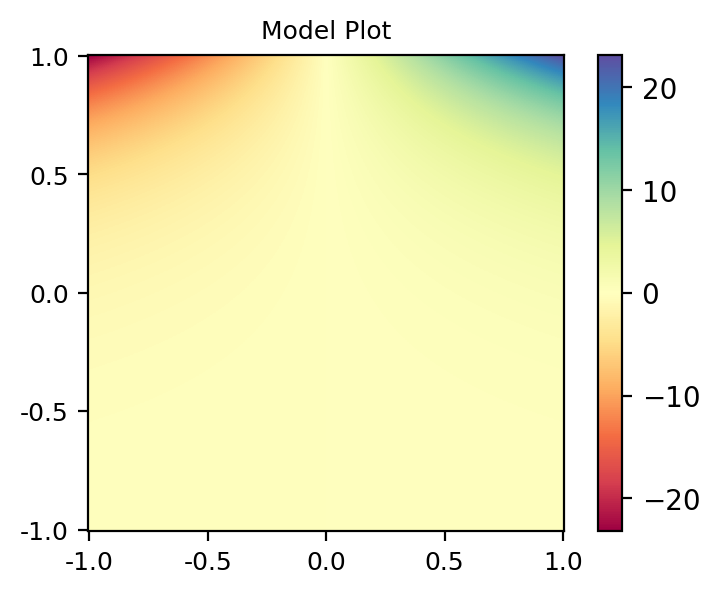

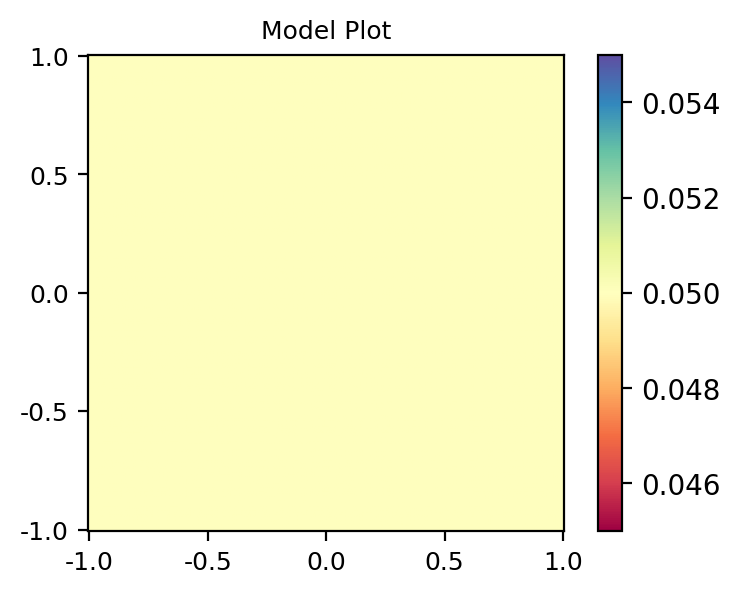

In [56]:
suffix = None#"poisson2d"
solver.plot_model(suffix=suffix)
#solver.plot_gt(suffix=suffix)
#solver.plot_abs_err(suffix=suffix)
#solver.plot_losses(lower=0, upper=-1)

### Errors

In [20]:
# [p] -1
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

# nu
print(np.abs(model_nu.fc.weight[0].detach().numpy()-nu))

L1  Error: [2.6313653139173213e-14]
L2  Error: [1.2878821624670717e-13]
Max Error: [1.2071538213476174e-11]
[2.91433544e-16]


In [21]:
# [p] -1/2
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

# nu
print(np.abs(model_nu.fc.weight[0].detach().numpy()-nu))

L1  Error: [2.2226233114930382e-14]
L2  Error: [3.84280521360955e-14]
Max Error: [8.02254096488042e-13]
[1.16573418e-15]


In [37]:
# [p] - 2/3
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

# nu
print(np.abs(model_nu.fc.weight[0].detach().numpy()-nu))

L1  Error: [1.7037464403351363e-14]
L2  Error: [3.2317100581204505e-14]
Max Error: [2.090147499522743e-12]
[5.689893e-16]


In [57]:
# [p] - 2/3, lob
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

# nu
print(np.abs(model_nu.fc.weight[0].detach().numpy()-nu))

L1  Error: [3.0008099024412346e-14]
L2  Error: [4.4186925582705e-14]
Max Error: [1.652011860642233e-12]
[6.24500451e-17]


In [72]:
# [p] - 1/3, lob
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

# nu
print(np.abs(model_nu.fc.weight[0].detach().numpy()-nu))

L1  Error: [7.48078706612278e-14]
L2  Error: [1.0812721000064126e-13]
Max Error: [6.394884621840902e-13]
[4.92661467e-16]


In [87]:
# [p] - 3/4, lob
print(f'L1  Error: {solver.lp_err(1)}')
print(f'L2  Error: {solver.lp_err(2)}')
print(f'Max Error: {solver.lp_err(np.inf)}')

# nu
print(np.abs(model_nu.fc.weight[0].detach().numpy()-nu))

L1  Error: [2.889591865658428e-14]
L2  Error: [4.9031239606145736e-14]
Max Error: [2.199060378238471e-12]
[1.05471187e-15]
